In [149]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations

In [173]:
#phase_dir = '../phased_ihart.ms2_del'
#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#assembly = '38'

phase_dir = '../phased_ssc.hg38_del'
ped_file = '../../DATA/ssc.hg38/ssc.ped'
assembly = '38'

In [174]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths37 = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
#	'Y': 59373566
}

# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths38 = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
	'X': 156040895,
#	'Y': 57227415
}

if assembly == '38':
    chrom_lengths = chrom_lengths38
else:
    chrom_lengths = chrom_lengths37

In [175]:
nahr_deletions = set()

with open('../data/segmental_duplication/hg38.chr_only.SDs.bed', 'r') as f:
    header = next(f).strip().split('\t')
    chrom1_index, start1_index, end1_index, strand1_index = header.index('#chr1'), header.index('start1'), header.index('end1'), header.index('strand1')
    chrom2_index, start2_index, end2_index, strand2_index = header.index('chr2'), header.index('start2'), header.index('end2'), header.index('strand2')
    
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[chrom1_index] == pieces[chrom2_index] and pieces[strand1_index]==pieces[strand2_index]:
            start1, end1, start2, end2 = int(pieces[start1_index]), int(pieces[end1_index]), int(pieces[start2_index]), int(pieces[end2_index])
            
            nahr_deletions.add((pieces[chrom1_index][3:], start1, end1, start2, end2))
                

print(len(nahr_deletions))

9312


In [176]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
			if pieces[2] != '0' and pieces[3] != '0':
				parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children
sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

In [177]:
crossovers = []
num_quads = 0
for file in sorted(os.listdir(phase_dir)):
    if file.endswith('.crossovers.json'):
        with open('%s/%s' % (phase_dir, file), 'r') as f:
            cos = json.load(f)
              
        if (len(cos)>22*4) and (len([x for x in cos if x['is_mat'] and not x['is_complex']])>22) and (len([x for x in cos if x['is_pat'] and not x['is_complex']])>22):
            child1, child2 = cos[0]['child']
            if len(cos)>=250:
               # print('Are they related?', child1, child2, file)
                pass
            else:
                crossovers.extend(cos)
                num_quads += 1
            
print(len(crossovers))



279693


In [178]:
with open('%s/deletions.json' % phase_dir, 'r') as f:
    deletions = json.load(f)
                          
print(len(deletions))


532131


In [179]:
print(deletions[0])

{'family': '11659', 'chrom': '12', 'start_pos': 10610, 'end_pos': 11162, 'length': 553, 'opt_start_pos': 10610, 'opt_end_pos': 12607, 'trans': ['SSC02968', 'SSC02962'], 'notrans': [], 'family_size': 4, 'is_mat': False, 'is_pat': True, 'mother': 'SSC02964', 'father': 'SSC02967', 'is_denovo': False, 'is_inherited': True}


In [180]:
print(sorted(nahr_deletions)[0])

('1', 10001, 37148, 180565, 207666)


In [181]:
is_nahr = np.zeros((len(deletions),), dtype=bool)
for chrom in [str(x) for x in range(1, 23)]:
    chrom_dels = [(i, d) for i, d in enumerate(deletions) if d['chrom']==chrom]
    nahr_dels = [n for n in nahr_deletions if n[0]==chrom]
    
    for i, d in chrom_dels:
        for c, st1, en1, st2, en2 in nahr_dels:
            if min(en1, d['start_pos'])-max(st1, d['opt_start_pos'])>0 and min(en2, d['opt_end_pos'])-max(st2, d['end_pos'])>0:
                is_nahr[i] = True
            elif min(en2, d['start_pos'])-max(st2, d['opt_start_pos'])>0 and min(en1, d['opt_end_pos'])-max(st1, d['end_pos'])>0:
                is_nahr[i] = True
                
print(np.sum(is_nahr), np.sum(is_nahr)/len(is_nahr))
    

25233 0.0474187747002148


In [182]:
c = np.zeros((2, 2, 2), dtype=int)
e = np.zeros((2, 2), dtype=int)
m = np.zeros((2, 2), dtype=int)
for i, d in enumerate(deletions):
    for child in d['trans']:
        c[int(is_nahr[i]), int(sample_to_affected[child]=='2'), int(d['is_mat'])] += 1
        
    m[int(is_nahr[i]), int(d['is_mat'])] += 1
        

print(np.sum(c, axis=2))
print(stats.chi2_contingency(np.sum(c, axis=2)))
print(c[:, :, 0])
print(stats.chi2_contingency(c[:, :, 0]))
print(c[:, :, 1])
print(stats.chi2_contingency(c[:, :, 1]))
print(m)
print(stats.binom_test(m[1, :]))

[[309440 384468]
 [ 15216  19004]]
(0.21305883195686862, 0.6443804142729201, 1, array([[309398.06688934, 384509.93311066],
       [ 15257.93311066,  18962.06688934]]))
[[154008 191691]
 [  7591   9511]]
(0.16898435977131332, 0.6810160210310129, 1, array([[153981.41874195, 191717.58125805],
       [  7617.58125805,   9484.41874195]]))
[[155432 192777]
 [  7625   9493]]
(0.054362774535403446, 0.8156385157965065, 1, array([[155416.69494179, 192792.30505821],
       [  7640.30505821,   9477.69494179]]))
[[251816 255082]
 [ 12672  12561]]
0.4886356813084456


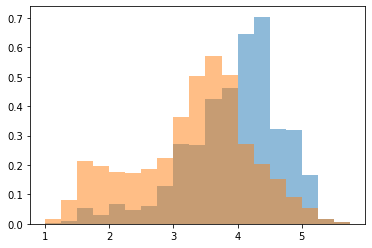

In [187]:
plt.hist(np.log10([d['length'] for d, i in zip(deletions, is_nahr) if i]), alpha=0.5, density=True, bins=np.arange(1, 6, 0.25))
plt.hist(np.log10([d['length'] for d, i in zip(deletions, is_nahr) if not i]), alpha=0.5, density=True, bins=np.arange(1, 6, 0.25))
plt.show()

In [51]:
for chrom in [str(x) for x in range(1, 23)]:
    print(chrom)
    chrom_cos = [x for x in crossovers if x['chrom']==chrom]
    chrom_dels = [x for x in deletions if x['chrom']==chrom]
    
    co_starts = np.array([x['start_pos'] for x in chrom_cos])
    co_ends = np.array([x['end_pos'] for x in chrom_cos])
    co_lengths = co_ends-co_starts
    
    for d in chrom_dels:
        d['start_overlaps'] = np.sum(np.clip(np.minimum(co_ends, d['start_pos'])-np.maximum(co_starts, d['opt_start_pos']), 0, None)/co_lengths)
        d['end_overlaps'] = np.sum(np.clip(np.minimum(co_ends, d['opt_end_pos'])-np.maximum(co_starts, d['end_pos']), 0, None)/co_lengths)
   
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


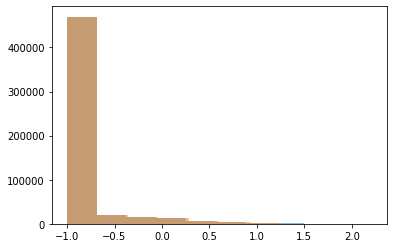

In [52]:
plt.hist(np.clip(np.log10([d['start_overlaps'] for d in deletions]), -1, None), alpha=0.5)
plt.hist(np.clip(np.log10([d['end_overlaps'] for d in deletions]), -1, None), alpha=0.5)
plt.show()

In [53]:
baseline_rate = 1/3000000000
print(baseline_rate)

3.333333333333333e-10


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


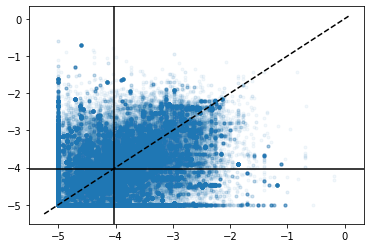

In [54]:
plt.scatter(np.clip(np.log10([d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) for d in deletions]), -5, None),
           np.clip(np.log10([d['end_overlaps']/(d['opt_end_pos']-d['end_pos']) for d in deletions]), -5, None), alpha=0.05, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(np.log10(baseline_rate*len(crossovers)), color='black')
plt.axvline(np.log10(baseline_rate*len(crossovers)), color='black')
plt.show()

In [55]:
print(np.sum([(d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) > baseline_rate*len(crossovers)) and (d['end_overlaps']/(d['opt_end_pos']-d['end_pos']) > baseline_rate*len(crossovers)) for d in deletions]))




//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


143319


In [56]:
print(len(deletions))

532131


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
//anaconda3

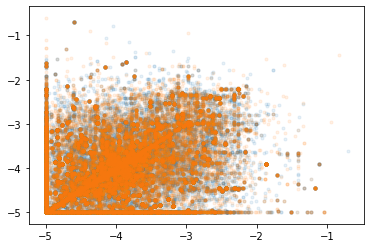

In [57]:
#plt.hist(np.clip(np.log10([d['start_overlaps'] for d in deletions if len(d['trans'])==2]), -1, None), alpha=0.5)
plt.scatter(np.clip(np.log10([d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='2']), -5, None), 
            np.clip(np.log10([d['end_overlaps']/(d['opt_end_pos']-d['end_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='2']), -5, None), alpha=0.1, marker='.')
plt.scatter(np.clip(np.log10([d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='1']), -5, None), 
            np.clip(np.log10([d['end_overlaps']/(d['opt_end_pos']-d['end_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='1']), -5, None), alpha=0.1, marker='.')
plt.show()



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


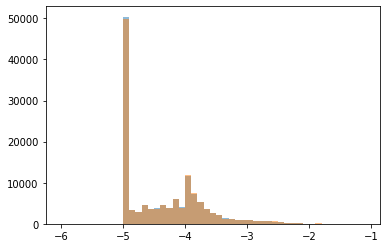

In [61]:
#plt.hist(np.clip(np.log10([d['start_overlaps'] for d in deletions if len(d['trans'])==2]), -1, None), alpha=0.5)
plt.hist(np.clip(np.log10([d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='2']), -5, None), alpha=0.5, bins=np.arange(-6, -1, 0.1))
plt.hist(np.clip(np.log10([d['start_overlaps']/(d['start_pos']-d['opt_start_pos']) for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='1']), -5, None), alpha=0.5, bins=np.arange(-6, -1, 0.1))
plt.show()



In [62]:
# Recombination and deletion hotspots

In [65]:
binsize=100000
positions = set()
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    positions.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+2*binsize, binsize)])
        
positions = sorted(positions)
chroms = [c for c, p in positions]
poss = np.array([p for c, p in positions])
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])


In [66]:
region_size = np.zeros((len(positions),), dtype=int)
indices = np.where([chroms[i]==chroms[i+1] for i in range(len(chroms)-1)])[0]
region_size[indices] = (poss[1:]-poss[:-1])[indices]

In [67]:
#print(chroms)
print(poss)
print(region_size)

[        0    100000    200000 ... 156000000 156100000 156200000]
[100000 100000 100000 ... 100000 100000      0]


In [103]:
recomb_mat = np.zeros((len(positions),))
recomb_pat = np.zeros((len(positions),))

already_included_recomb = set()
for co in crossovers:
    if co['is_mat']:
        start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
        for index in range(start_index, end_index):
            overlap = 0
            if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
            if overlap>0:
                recomb_mat[index] += overlap/(co['end_pos']-co['start_pos'])
    if co['is_pat']:
        start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
        for index in range(start_index, end_index):
            overlap = 0
            if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
            if overlap>0:
                recomb_pat[index] += overlap/(co['end_pos']-co['start_pos'])
    already_included_recomb.update(co['child'])

recomb_mat = recomb_mat/len(crossovers)
recomb_pat = recomb_pat/len(crossovers)

recomb_mat_clipped = np.clip(recomb_mat, 3/len(crossovers), None)
recomb_pat_clipped = np.clip(recomb_pat, 3/len(crossovers), None) 


In [104]:
print(len(already_included_del))

4308


In [117]:
del_rate = np.zeros((len(positions),))
del_aut = np.zeros((len(positions),))
del_nt = np.zeros((len(positions),))

already_included_del = set()
for d in deletions:
    start_pos, end_pos = d['opt_start_pos'], d['start_pos']
    start_index, end_index = pos_to_index[(d['chrom'], int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(d['chrom'], int(np.ceil(end_pos/binsize)*binsize))]+1
    for index in range(start_index, end_index):
        overlap = 0
        if chroms[index]==d['chrom'] and chroms[index+1]==d['chrom']:
            overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
        if overlap>0:
            del_rate[index] += overlap/(end_pos-start_pos)
            if len(d['trans'])==1 and len(d['notrans'])==1:
                if sample_to_affected[d['trans'][0]]=='2':
                    del_aut[index] += overlap/(end_pos-start_pos)
                elif sample_to_affected[d['trans'][0]]=='1':  
                    del_nt[index] += overlap/(end_pos-start_pos)
            
    
    start_pos, end_pos = d['end_pos'], d['opt_end_pos']
    start_index, end_index = pos_to_index[(d['chrom'], int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(d['chrom'], int(np.ceil(end_pos/binsize)*binsize))]+1
    for index in range(start_index, end_index):
        overlap = 0
        if chroms[index]==d['chrom'] and chroms[index+1]==d['chrom']:
            overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
        if overlap>0:
            del_rate[index] += overlap/(end_pos-start_pos)
            if len(d['trans'])==1 and len(d['notrans'])==1:
                if sample_to_affected[d['trans'][0]]=='2':
                    del_aut[index] += overlap/(end_pos-start_pos)
                elif sample_to_affected[d['trans'][0]]=='1':  
                    del_nt[index] += overlap/(end_pos-start_pos)
    
    already_included_del.update(d['trans'])
    already_included_del.update(d['notrans'])

del_rate = del_rate/(2*len(deletions))
del_aut = del_aut/(2*len([d for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='2']))
del_nt = del_nt/(2*len([d for d in deletions if len(d['trans'])==1 and len(d['notrans'])==1 and sample_to_affected[d['trans'][0]]=='1']))

del_rate_clipped = np.clip(del_rate, 3/(2*len(deletions)), None)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


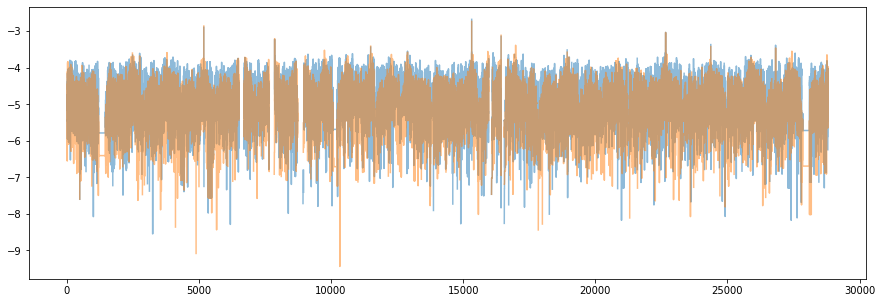

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(recomb_mat), alpha=0.5)
plt.plot(np.log10(recomb_pat), alpha=0.5)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


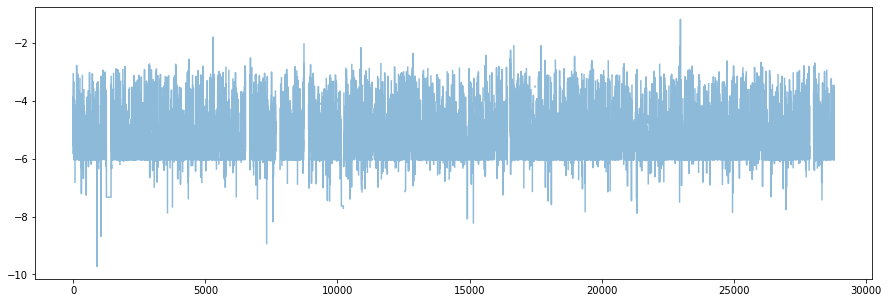

In [107]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(del_rate), alpha=0.5)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


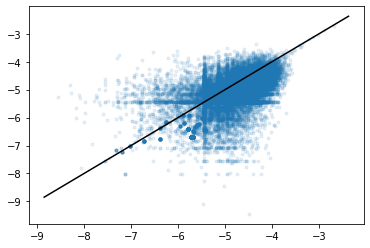

In [111]:
plt.scatter(np.log10(recomb_mat), np.log10(recomb_pat), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


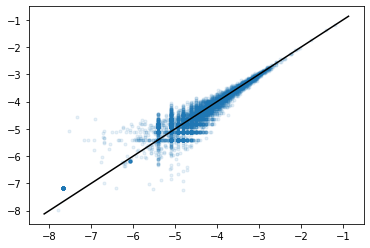

In [118]:
plt.scatter(np.log10(del_aut), np.log10(del_nt), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


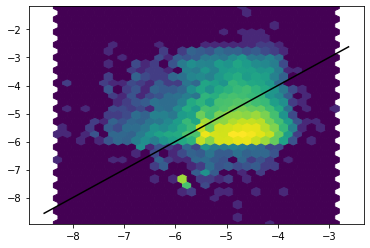

In [122]:
plt.hexbin(np.log10(recomb_mat), np.log10(del_rate), bins='log', gridsize=30)
plt.plot(plt.xlim(), plt.xlim(), color='black')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


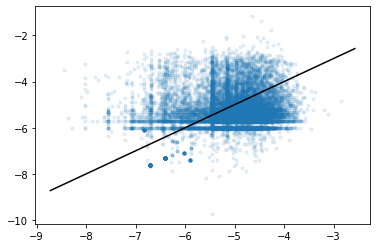

In [113]:
plt.scatter(np.log10(recomb_pat), np.log10(del_rate), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black')
plt.show()